In [15]:
import os, sys, time, importlib, json, copy
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from OuterDeployment.HarrisCorner import *
from SensorModule.Sensor import Sensor
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [16]:
# 사용할 알고리즘
from InnerDeployment.GeneticAlgorithm import SensorGA

In [17]:
vis=VisualTool(show=True, size=(3,3))
map=MapLoader().load("map_280x250.bot")
sensor=Sensor(map)
corner=HarrisCorner(map)


In [18]:
corner_layer = corner.run(map, blockSize=3, ksize=5, k=0.05, dilate_size=5)
print(corner_layer, len(corner_layer))

[(45, 1), (54, 14), (17, 25), (13, 29), (31, 29), (47, 35), (43, 40), (56, 40), (40, 44)] 9


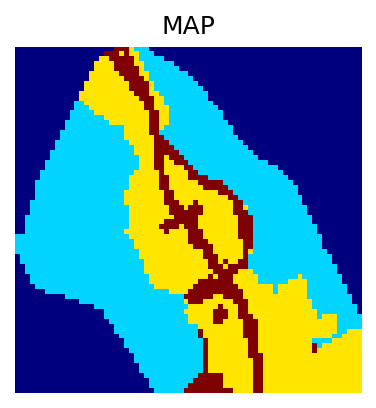

Saved figure: __RESULTS__/01-08-01-13/jet_map.png


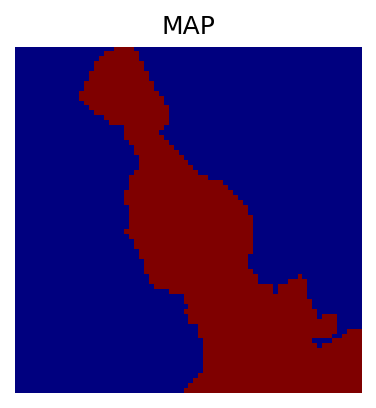

Saved figure: __RESULTS__/01-08-01-13/jet_map.png


In [20]:
map=MapLoader().load("gangjin.crop2")
installable_layer = layer_map(map, keep_values=[2, 3])
vis.showJetMap(map)
vis.showJetMap(installable_layer)